# Dark JV analysis

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.ticker as ticker
import pandas as pd

# Enable interactive plots in Jupyter Notebook
%matplotlib nbagg

# Set the path to the foldercontaining text files
light_folder_path = "C:\\Users\\w16025698\\OneDrive - Northumbria University - Production Azure AD\\PhD\\Characterisation\\JV\\230221J_JV"
dark_folder_path = "C:\\Users\\w16025698\\OneDrive - Northumbria University - Production Azure AD\\PhD\\Characterisation\\JV\\230221J_JV\\Dark"
light_file_name = "A3.txt"
dark_file_name = "230221A3_DARKJV.txt"

# Read the data from the text file, skipping the first 12 lines
light_data = np.loadtxt(os.path.join(light_folder_path, light_file_name), skiprows=12)
dark_data = np.loadtxt(os.path.join(dark_folder_path, dark_file_name), skiprows=1)

# Extract the voltage and current data from the columns
V_light = light_data[:,0]
I_light = light_data[:,1] 
mV_light = V_light * 1000
mA_light = I_light * 1000

V_dark = dark_data[:,0]
I_dark = -dark_data[:,1] 
mV_dark = V_dark * 1000
mA_dark = I_dark * 1000

# Cell area cm2 and incident power density mW/cm2
cell_area = 0.16
incident_power_density = 100

# Current density mA/cm2
current_density_light = -mA_light / cell_area
current_density_dark = -mA_dark / cell_area

## Interpolation

In [2]:
# Interpolate more data points
jv_interp = interp1d(mV_light, current_density_light, kind='linear', bounds_error=False, fill_value="extrapolate")
mV_light_i = np.linspace(-100, 700, 400)
current_density_light_i = jv_interp(mV_light_i)

jv_interp = interp1d(mV_dark, current_density_dark, kind='linear', bounds_error=False, fill_value="extrapolate")
mV_dark_i = np.linspace(-100, 700, 400)
current_density_dark_i = jv_interp(mV_dark_i)

# Calculate the power density from the voltage and current density data : units mW/cm2
power_density = -current_density_light_i * mV_light_i / 1000

# Indices of max power point
max_power_index = np.argmax(power_density)

## Value Determination for light JV

In [3]:
# Create a data frame to store device data
df = pd.DataFrame(columns=['file_name', 'efficiency', 'open_circuit_voltage', 'short_circuit_current', 'fill_factor', 'Rs', 'Rsh'])

# Calculate the open circuit voltage, short circuit current, fill factor and efficiency

short_circuit_index = np.where(np.diff(np.sign(mV_light_i)))
short_circuit_current = current_density_light_i[short_circuit_index]
open_circuit_index = np.where(np.diff(np.sign(current_density_light_i)))
open_circuit_voltage = mV_light_i[open_circuit_index]
fill_factor = (mV_light_i[max_power_index]*current_density_light_i[max_power_index])/(open_circuit_voltage[0] *short_circuit_current[0])
efficiency = -short_circuit_current[0] * open_circuit_voltage[0] * fill_factor / incident_power_density /10

# gradient calculation
grad = np.gradient(current_density_light_i, mV_light_i)
Voc_slope = grad[open_circuit_index]
Rs = 1/ np.abs(Voc_slope)
Jsc_slope = grad[0]
Rsh = 1/np.abs(Jsc_slope)

df = df.append({'file_name': light_file_name, 'efficiency': efficiency, 'open_circuit_voltage': open_circuit_voltage[0], 'short_circuit_current': short_circuit_current[0], 'fill_factor': fill_factor, 'Rs': Rs[0], 'Rsh': Rsh}, ignore_index=True)
display(df)

,file_name,efficiency,open_circuit_voltage,short_circuit_current,fill_factor,Rs,Rsh
0,A3.txt,4.778384,413.283208,-25.019418,0.462121,5.135829,222.107509


## Current Density Plot

<IPython.core.display.Javascript object>


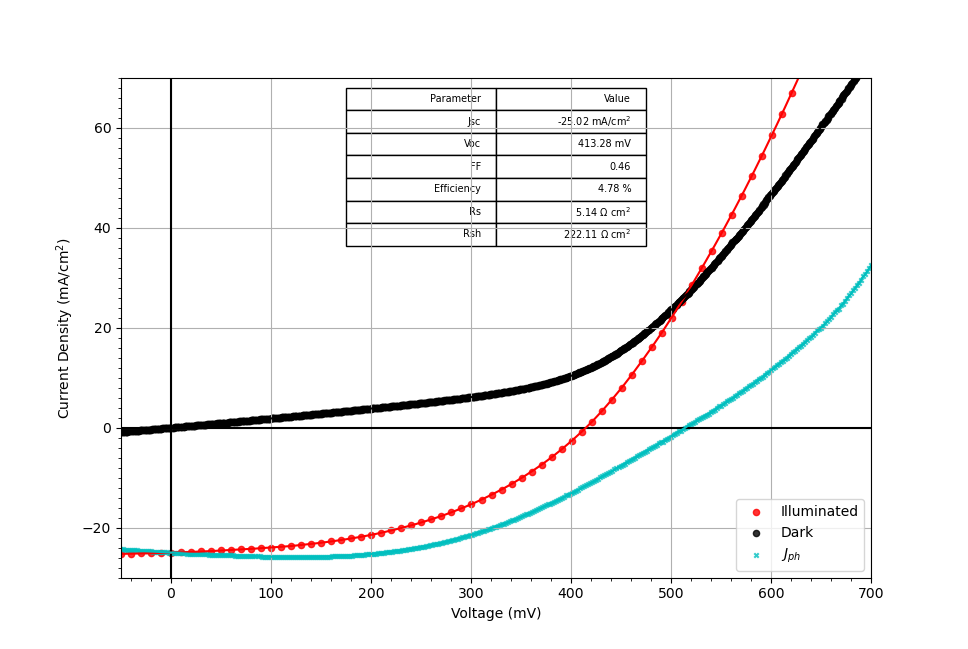

In [4]:
# Plot the JV curve and the power curve on the same plot
fig, ax1 = plt.subplots()

# Figure formatting
ax1.set_xlabel("Voltage (mV)")
ax1.set_ylabel("Current Density (mA/cm$^2$)")
ax1.set_ylim(-30, 70)
ax1.set_xlim(-50, 700)
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(20))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(2))
ax1.grid()
plt.axhline(0, color='k')
plt.axvline(0, color='k')
ax1.tick_params(axis='y', labelcolor='k')

# Plot the light JV curve
ax1.scatter(mV_light, current_density_light, c='r', alpha=0.8, marker='o', s=20, label='Illuminated')
ax1.plot(mV_light_i, current_density_light_i, color='r')

# Plot Dark JV curve 
ax1.scatter(mV_dark, current_density_dark, c='k', alpha=0.8, marker='o', s=20, label='Dark')
ax1.plot(mV_dark_i, current_density_dark_i, color='k')

# Plot of Jph = Jl - Jd
Jph = current_density_light_i - current_density_dark_i
ax1.scatter(mV_dark_i, Jph, c='c', alpha=0.8, marker='x', s=10, label='$J_{ph}$')
ax1.plot(mV_dark_i, Jph, color='c')

# Add a table with parameters
table_data = [
    ['Parameter', 'Value'],
    ['Jsc', "{:.2f}".format(short_circuit_current[0]) + ' mA/cm$^2$'],
    ['Voc', "{:.2f}".format(open_circuit_voltage[0]) + ' mV'],
    ['FF', "{:.2f}".format(fill_factor)],
    ['Efficiency', "{:.2f}".format(efficiency) + ' %'],
    ['Rs', "{:.2f}".format(Rs[0]) + ' \u03A9 cm$^2$'],
    ['Rsh', "{:.2f}".format(Rsh) + ' \u03A9 cm$^2$'],
]

table = plt.table(cellText=table_data, colWidths=[0.4, 0.4], loc='upper center')
table.auto_set_font_size(True)
#table.set_fontsize(7)
table.scale(0.5, 1.0)


ax1.legend()


## Dark JV logarithmic plot

<IPython.core.display.Javascript object>


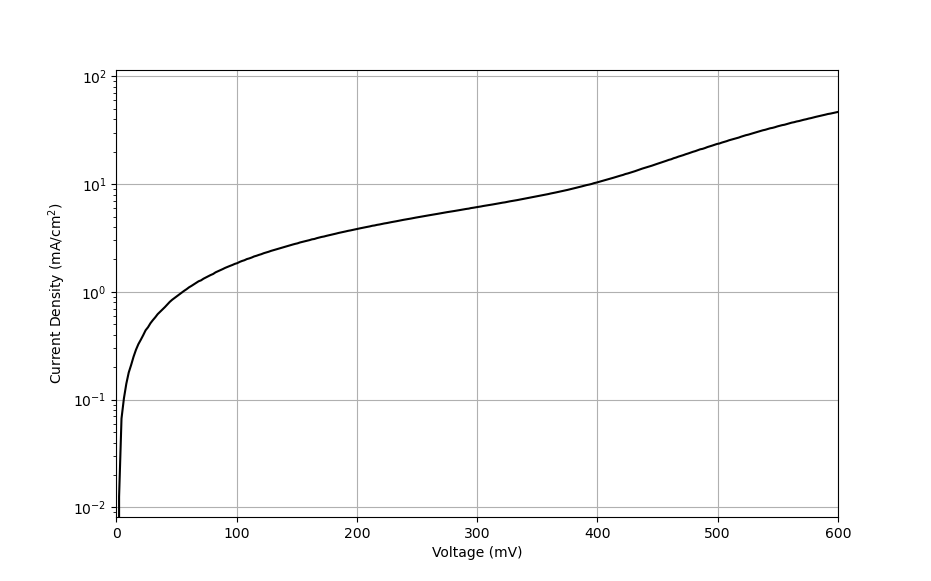

In [5]:
# Plot the JV curve and the power curve on the same plot
fig, ax1 = plt.subplots()

# Figure formatting
ax1.set_xlabel("Voltage (mV)")
ax1.set_ylabel("Current Density (mA/cm$^2$)")
#ax1.set_ylim(0, 0.10)
ax1.set_xlim(0, 600)
#ax1.xaxis.set_minor_locator(ticker.MultipleLocator(20))
#ax1.yaxis.set_minor_locator(ticker.MultipleLocator(2))
ax1.grid()
ax1.tick_params(axis='y', labelcolor='k')

# Plot Dark JV curve 
#ax1.scatter(mV_dark, current_density_dark, c='k', alpha=0.2, marker='o', s=20)
ax1.semilogy(mV_dark_i, current_density_dark_i, color='k')

## Derivative g(V) Plot
$$
g(V) \equiv \frac{dJ}{dV}
$$

***
$$
J = J_0 exp \left[ \frac{q}{AkT}(V-RJ) \right]+GV-J_L
$$

where $G$ is shunt conductance.

***
* If the shunt term is ohmic and $J_L$ is constant, $g(V)$ will be ﬂat with
the value in reverse bias equal to $G$. 
* In practice, the slope of most $JV$ curves is very small in this range so there may be some noise in calculating the derivative, particularly under illumination.
***
Parisitic Effects
* Deviation of $g(V)$ away from its minimum shows voltage dependance of the shunt conductance $G(V)$
* in this case the minimum value of $g(V)$ gives an upper bound of the shunt conductance $G(V)$

<IPython.core.display.Javascript object>


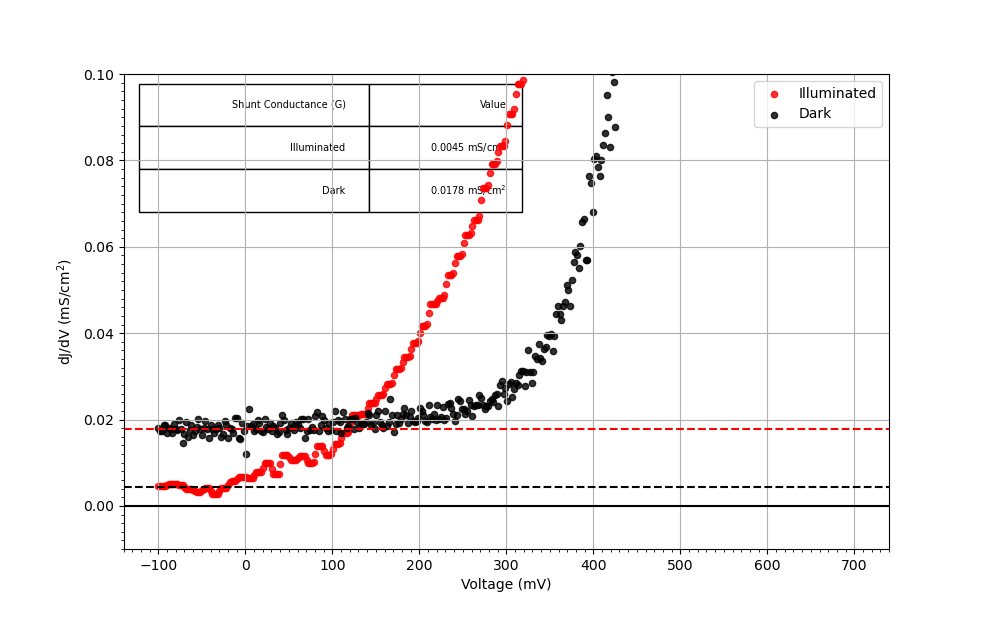

In [7]:
# dJ/dV calculation
g_grad_light = np.gradient(current_density_light_i, mV_light_i) 
g_grad_dark  = np.gradient(current_density_dark_i, mV_dark_i)

# Define a function to find the flat portion of the curve
def find_flat_portion(x, y, threshold=0):
    flat_mask = x < threshold  # Create a boolean mask for x values less than the threshold
    flat_y = y[flat_mask]     # Filter the y values using the mask
    return flat_y

# Threshold for x values less than 0
threshold = 0

# Find the flat portion of the "Illuminated" curve (g_grad_light) & "Dark" curve (g_grad_dark)
flat_portion_light = find_flat_portion(mV_light_i, g_grad_light, threshold)
flat_portion_dark = find_flat_portion(mV_dark_i, g_grad_dark, threshold)

# Calculate the y values for the flat portions
G_value_light = np.mean(flat_portion_light)  # You can use mean or other relevant metrics
G_value_dark = np.mean(flat_portion_dark)


# Figure formatting
fig, ax1 = plt.subplots()
ax1.set_xlabel("Voltage (mV)")
ax1.set_ylabel("dJ/dV (mS/cm$^2$)")
ax1.set_ylim(-0.01, 0.1)
# ax1.set_xlim(-100, 300)
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(10))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.002))
plt.axhline(G_value_light, color='k', linestyle='--')
plt.axhline(G_value_dark, color='r', linestyle='--')
ax1.grid()
plt.axhline(0, color='k')
#plt.axvline(0, color='k')
ax1.tick_params(axis='y', labelcolor='k')

# Add a table with parameters
table_data = [
    ['Shunt Conductance (G)', 'Value'],
    ['Illuminated', "{:.4f}".format(G_value_light) + ' mS/cm$^2$'],
    ['Dark', "{:.4f}".format(G_value_dark) + ' mS/cm$^2$'],
]

table = plt.table(cellText=table_data, colWidths=[0.6, 0.4], loc='upper left')
table.auto_set_font_size(False)
table.set_fontsize(7)
table.scale(0.5, 2.0)


# Light differential Plot
ax1.scatter(mV_light_i, g_grad_light, c='r', alpha=0.8, marker='o', s=20, label='Illuminated')

# Dark differential plot
ax1.scatter(mV_dark_i, g_grad_dark, c='k', alpha=0.8, marker='o', s=20, label='Dark')

ax1.legend()

## Derivative r(J) plot

# FIX THIS


$$
r(J) \equiv \frac{dV}{dJ} = R + \frac{AkT}{q}(J+J_{L})^{-1}
$$

when $RG<<1$
***
* A plot of $r(J)$ against $(J+J_{L})^{-1}$ will yield a straight line with intercept $R$ if $J_L$
is independent of voltage. 
* With constant $J_L$ we can write $J_L = J_{SC}$
* For analysis of the dark $JV$ curve, $J_{SC}=J_L=0$
* A linear ﬁt to the data gives an intercept of R and a slope AkT/q from which $A$ can be calculated. A correction can be made for the case in which $G$ is not negligible by plotting $(J+J_{SC} - GV)^{-1}$

Linear Fit for 'Illuminated' Curve:
Slope: 1.9510124941837954
Y-intercept: 253.9516972810512

Linear Fit for 'Dark' Curve:
Slope: -0.21866431546576595
Y-intercept: 57.52612772724643


C:\Users\W16025~1\AppData\Local\Temp/ipykernel_22872/1715995380.py:4: RuntimeWarning: divide by zero encountered in reciprocal
  JJsc_light   = (current_density_light_i + -short_circuit_current[0])**-1


<IPython.core.display.Javascript object>


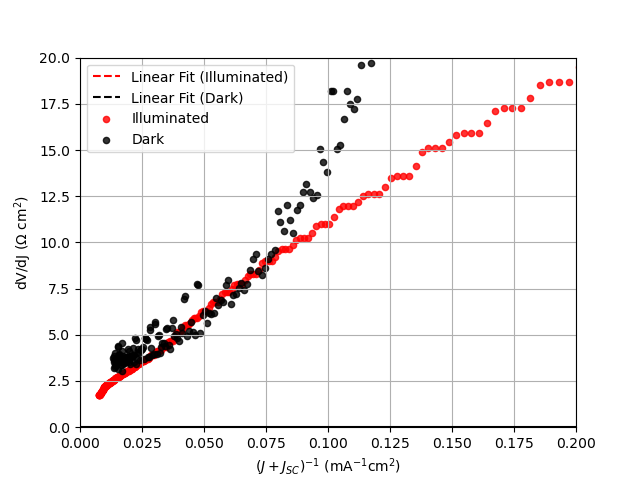

In [8]:
# dV/dJ calculation
r_grad_light = np.gradient(mV_light_i, current_density_light_i) 
r_grad_dark  = np.gradient(mV_dark_i, current_density_dark_i)
JJsc_light   = (current_density_light_i + -short_circuit_current[0])**-1
JJsc_dark    = (current_density_dark_i)**-1

# Define a function to fit a linear regression line and return the slope and y-intercept
def fit_linear_regression(x, y, threshold=0.05):
    # Find the index where x exceeds the threshold
    index_threshold = np.argmax(x > threshold)
    
    # Slice the data to keep only the linear portion
    x_linear = x[:index_threshold]
    y_linear = y[:index_threshold]
    
    # Fit a linear regression line to the linear portion
    coefficients = np.polyfit(x_linear, y_linear, 1)
    slope = coefficients[0]
    intercept = coefficients[1]
    
    return slope, intercept

# Threshold for identifying the linear portion of the data
threshold = 0.075  # Adjust this threshold as needed

# Fit linear regression for the "Illuminated" curve & "Dark" curve
slope_light, intercept_light = fit_linear_regression(JJsc_light, r_grad_light, threshold)
slope_dark, intercept_dark = fit_linear_regression(JJsc_dark, r_grad_dark, threshold)

# Print the slope and y-intercept for both curves
print("Linear Fit for 'Illuminated' Curve:")
print("Slope:", slope_light)
print("Y-intercept:", intercept_light)

print("\nLinear Fit for 'Dark' Curve:")
print("Slope:", slope_dark)
print("Y-intercept:", intercept_dark)

# Figure formatting
fig, ax1 = plt.subplots()
ax1.set_xlabel("$(J+J_{SC})^{-1}$ (mA$^{-1}$cm$^{2}$)")
ax1.set_ylabel("dV/dJ ($\Omega$ cm$^2$)")
ax1.set_ylim(0, 20)
ax1.set_xlim(0, 0.2)
#ax1.xaxis.set_minor_locator(ticker.MultipleLocator(10))
#ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.002))
ax1.grid()
plt.axhline(0, color='k')
#plt.axvline(0, color='k')
ax1.tick_params(axis='y', labelcolor='k')

# Light & Dark differential Plot
ax1.scatter(JJsc_light, r_grad_light, c='r', alpha=0.8, marker='o', s=20, label='Illuminated')
ax1.scatter(JJsc_dark, r_grad_dark, c='k', alpha=0.8, marker='o', s=20, label='Dark')
ax1.plot(JJsc_light, slope_light * JJsc_light + intercept_light, 'r--', label='Linear Fit (Illuminated)')
ax1.plot(JJsc_dark, slope_dark * JJsc_dark + intercept_dark, 'k--', label='Linear Fit (Dark)')

ax1.legend()